
# **MIS710 Week 11: Self-Study**
Author: Associate Professor Lemai Nguyen

Objectives:
1. To practice NLP sentiment analysis using **multi-class** classification
2. To learn basic MLOps: saving your model and loading and using it later.
3. Data pipeline

Note: There is a separate MIS710_Lab11_NLP_Deployment where you can load the saved model and apply it to make predictions.

# **1. Case One: ChatGPT tweets**

**Sentiment analysis**

**Context**

ChatGPT has reached 100 million users just two months after launching. There is a huge debate on general trends and concerns surrounding AI and language models. A diverse range of opinions and viewpoints is emerging.

**Content**

The lab dataset is a cutdown version of a kaggle dataset of 100,000 tweets in English containing the word "chatgpt" between 2023-03-18 and 2023-03-21.

The Lab dataset consists of Processed tweet and Sentiment lables.

**Inspiration**

Analysing public sentiment through datasets like Tweets can provide valuable insights into the opinions and attitudes towards ChatGPT. It's not uncommon for opinions to be divided or for individuals to have mixed feelings about a new technology or innovation.

**Data source**:

https://www.kaggle.com/datasets/sanlian/tweets-about-chatgpt-march-2023


In [25]:
# import libraries
import pandas as pd #for data manipulation and analysis
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

Import classes and functions for ML tasks

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [27]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## **1.1 Data Loading**

In [28]:
url='https://raw.githubusercontent.com/VanLan0/MIS710-ML/main/Datasets/chatgpt-tweets.csv'


In [29]:
# load dataset
records = pd.read_csv(url, index_col=None)

In [30]:
records.head()

,processed_tweet,sentiment_label
0,chatgpt is another woke machine.,negative
1,"of the atlantic, or only near the atla more to...",neutral
2,this thread is saved to your notion database. ...,neutral
3,prompt ai – chatgpt,neutral
4,just had some interesting conversations with g...,positive


In [31]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80501 entries, 0 to 80500
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   processed_tweet  80500 non-null  object
 1   sentiment_label  80501 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


## **1.2. Data Preparation, Exploration and Visualisation**

### **1.2.1 Data cleansing**

* Inspect columns and correct data types
* Detecting and handling missing data


**Detect missing data**

In [32]:
records.isnull().sum()

processed_tweet    1
sentiment_label    0
dtype: int64

In [33]:
# Drop rows with missing data in the 'Age' column
records.dropna(subset=['processed_tweet'], inplace=True)

In [34]:
records.isnull().sum()

processed_tweet    0
sentiment_label    0
dtype: int64

### **1.2.2 EDA**

* Analyse and visualise the sentiment column

In [35]:
# Get frequency of positive and negative reviews
sentiment_counts = records['sentiment_label'].value_counts()
print(sentiment_counts)

neutral     40618
negative    20911
positive    18971
Name: sentiment_label, dtype: int64


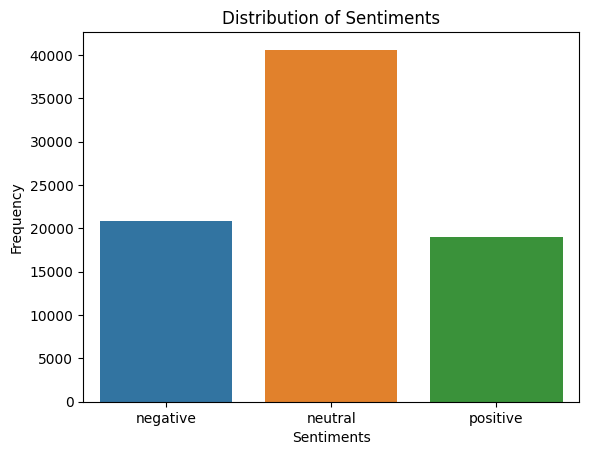

In [36]:
# Plot bar chart of sentiment counts
sns.countplot(data=records, x='sentiment_label')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.show()

**Question.** Over half is sitting on the fence. How about you?

### **1.2.3 Text pre-processing**
* Text cleaning: Remove any HTML tags, punctuation, and special characters from the reviews.
* Lowercasing: Convert all text to lowercase to ensure that words with the same spelling but different capitalization are treated as the same word.
* Tokenization: Split the text into individual words or tokens.
* Stopword removal: Remove common words such as "the", "and", "a", etc. that do not add much meaning to the text.
* Stemming/Lemmatization: Reduce words to their base form to normalize the text and group together words with similar meanings.

re is a built-in Python module for working with regular expressions. Regular expressions are a combination of alphanumeric characters and special characters. For example, the . character in a regular expression matches any single character, while the * character matches zero or more occurrences of the preceding character.

#### **Text cleaning**

In [37]:
import re

The re.sub() method takes three arguments:

1.   The regular expression pattern to search for.
2.   The replacement string to use for each match of the pattern.
3. The input string to perform the substitution on.

In [38]:
# Define function to clean text
def clean_text(text):
  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # Remove punctuation and special characters
  text = re.sub(r'[^\w\s]', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  # Remove the string 'nan' from column "Text", as we merged columns with missing texts together
  text = re.sub(r'nan', '', text)
  return text

* The . (dot) metacharacter matches any single character except for a newline character.
* The * (asterisk) metacharacter matches zero or more occurrences of the preceding character or group.

* \w matches any word character, which  includes all alphabetic characters (both upper- and lowercase) and digits, and the underscore character.

* \s matches any whitespace character, which includes spaces, tabs, newlines, and other types of whitespace.

* \s+ matches one or more consecutive whitespace characters. The + (plus) is a metacharacter that means "one or more occurrences of the preceding pattern".

**Task 1:** Write code for tweets to apply clean_text

In [39]:
# Write code to apply the clean_text function to the 'review' column
records['processed_tweet'] = records['processed_tweet'].apply(clean_text)

#### **Text lowercasing**

In [40]:
def lowercasing(text):
  # Convert to lowercase
  text = text.lower()
  return text

**Task 2:** Write code for tweets to apply lowercasing

In [41]:
#Write code for tweets to apply lowercasing
records['processed_tweet']=records['processed_tweet'].apply(lowercasing)

### **1.2.4 Linguistics preprocessing**

#### **Tokenization, Stemming and Lemmatization**

* Tokenization breaks the text into individual words or tokens, and then stemming/lemmatization is applied on each token individually to obtain their root form.

* Stemming can help in reducing  words to their root form, which can help in reducing the number of unique words and therefore reducing the size of the vocabulary. For example: studies, study, studied, studying -> studi; flew -> fle; import PorterStemmer for stemming.

* Lemmatization reduces a word to its base or dictionary form, which can improve the accuracy of the analysis; For example: studies, study, studied, studying -> study; flew -> fly;  import WordNetLemmatizer for lemmatization.

NLTK (Natural Language Toolkit) is a Python library used for natural language processing (NLP) tasks such as tokenization, stemming, lemmatization, part-of-speech tagging, and more.

In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

Punkt and WordNet are both modules in the Natural Language Toolkit (nltk) library in Python for natural language processing tasks.

* Punkt is a module used for tokenization. The Punkt module is trained on large corpora and uses unsupervised learning algorithms to tokenize sentences effectively even when presented with challenging text.

* WordNet is a large lexical database of English words for lemmatization.

In [43]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# Get stopwords
stop_words = set(stopwords.words('english'))
#keep negation words because removing them may result in information loss
negation_words = {'no', 'not', 'nor', 'neither', 'none', 'never'}

filtered_words = [word for word in stop_words if word not in negation_words]

In [45]:
#define a function to perform tokenization and lemmatization
def tokenize_lemmatize(text):
  #tokenization
  tokens = nltk.word_tokenize(text.lower())

  #initialize a lemmatizer
  lemmatizer = WordNetLemmatizer()

  #perform lemmatization
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in filtered_words and token.lower() not in negation_words]
  return ' '.join(lemmatized_tokens)

**Task 3**: Write code

In [46]:
# Write code to tokenize and lemmatize the text
processed_text = records['processed_tweet'].apply(tokenize_lemmatize)


### **1.2.5 Feature selection**

**Task 4**: Write code to select the feature and target

In [47]:
#Write code to select the feature and target
X=processed_text
y=records['sentiment_label']

### **1.2.6 Data splitting**

**Task 5:** Write code to split data, don't forget to use stratify=y

In [48]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2023)


In [49]:
X_train

42192    ai revolution shaking journalism bot like chat...
30445     possible advantage open ai chat gpt dynamic user
19791    people love throw around democratizing xyz don...
65600    perspective chatgpt ace logic test dont ask cr...
60080    thats cool im curious collaboration chatgpt mi...
                               ...                        
12956    google launch bard ai chatbot compete chatgpt via
26803    need le thread chatgpt scammy course keep mont...
57558    dont think ive single conversation anyone past...
3072     go beyond shock world indeed real reason craze...
43731    chatgpt4 launch bing becomes vital publisher o...
Name: processed_tweet, Length: 64400, dtype: object

### **1.2.7 Vectorization**

A vectorizer is a process of converting textual data into numerical vectors that can be used as input for machine learning algorithms.

* Using a bag-of-words model, a vectorizer counts the frequency of each word in a document and represents the document as a vector of word frequencies. The function CountVectorizer converts a collection of text documents to a matrix of token counts.
* Using TF-IDF (Term Frequency-Inverse Document Frequency). It quantifies the importance of a term within a document relative to a collection of documents (often called a corpus). The higher the TF-IDF score of a term, the more unique and significant it is to the specific document in the context of the entire corpus. This serves a feature extraction as well.

The vectorisation produces a sparse representation of the counts. Since most words in a vocabulary will not appear in a typical document, the resulting matrix will have many zeroes, hence it's sparse.

If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

**Optional:** You can apply n-gram vectorisation by specifying a range ngram_range=(min, max).

We might want to write ngram_range=(1,2) but to demonstrate the effect, you can use ngram_range=(2,2)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.7, ngram_range=(1, 2))

**Task 6:** write code to train the tfidf_vectorizer by fit_transform X_train and use it tranform X_test

In [51]:
#Write code to train the tfidf_vectorizer by fit_transform X_train and use it tranform X_test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

**Note**: Fit on the training data only, then transform i.e., vectorize both train and test datasets. The transform method converts X_test into a vectorized format based on the vocabulary learned from X_train. It doesn't update the vocabulary. So, any words in X_test that weren't in X_train will be ignored.

The following may take a shortwhile.

Option: if you use tfidf_vectorizer = TfidfVectorizer(max_df=0.7, ngram_range=(2, 2)) then check first 20 words from the vocabulary learned from the X_train and the size.

In [52]:
# Get the list of features (i.e., words)
features = tfidf_vectorizer.vocabulary_

# List the first 20 words
print(list(features)[:20])

['ai', 'revolution', 'shaking', 'journalism', 'bot', 'like', 'chatgpt', 'industry', 'announced', 'restructuring', 'would', 'see', 'significant', 'reduction', 'production', 'proofreading', 'latest', 'tech', 'news', 'today']


In [53]:
print('Vocabulary size:', len(features))

Vocabulary size: 421877


In [54]:
print('Trainning set:', len(y_train))
print('Testing set:', len(y_test))

Trainning set: 64400
Testing set: 16100


Now we have turned the reviews (in training and test) into a sparse matrix.

Let's inspect the datasets

In [55]:
def check_dataset(arg1, mydataset):
# Get frequency of positive and negative reviews
  unique, frequency = np.unique(mydataset, return_counts = True)
# print unique values array
  print(arg1, unique)
# print frequency array
  print(arg1, frequency)

check_dataset('Training: ', y_train)
check_dataset('Testing: ', y_test)

Training:  ['negative' 'neutral' 'positive']
Training:  [16729 32494 15177]
Testing:  ['negative' 'neutral' 'positive']
Testing:  [4182 8124 3794]


## **1.3. Sentiment analysis**

### **1.3.1 Logistic regression**

#### Model building

**Task 7**: Write code to initialise and fit a lr model with X_train_tfidf, y_train

In [56]:
# Write code to train the logistic regression model with X_train_tfidf, y_train
lr = LogisticRegression(penalty='l2', C=2, solver='liblinear', max_iter=1000, random_state=2023)
lr.fit(X_train_tfidf, y_train)


LogisticRegression(C=2, max_iter=1000, random_state=2023, solver='liblinear')

**Task 8**: Make predictions

In [57]:
# Write code to make predictions on X_test_tfidf
y_pred_lr = lr.predict(X_test_tfidf)

In [58]:
#get predicted probabilities for the main class
y_pred_probs_lr = lr.predict_proba(X_test_tfidf)
y_pred_probs_lr = y_pred_probs_lr[:, 1]

In [59]:
#join unseen y_test with predicted value into a data frame
inspection=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_lr})

#join X_test with the new dataframe
inspection=pd.concat([X_test,inspection], axis=1)

inspection.sample(20)

,processed_tweet,Actual,Predicted
40459,time crutchproviders integrate teleprompter ch...,neutral,neutral
36813,automate tweet earn campaign maximum efficienc...,neutral,neutral
72596,chatgpt kubrick clarke orthodox,neutral,neutral
55657,rise chatgpt adressing fear job loss among pro...,neutral,neutral
3858,google abre el acceso anticipado chatbot con i...,neutral,neutral
50912,new another chatgpt userinterface,neutral,neutral
55307,withdrawal still going whose fund locked,neutral,neutral
39715,wait could use chatgpt read term condition fin...,neutral,neutral
69078,actually asked chatgpt write interaction jack ...,negative,neutral
48084,started learning tekken today curiousity used ...,positive,negative


#### Performance evaluation
* Classification metrics and report
* Confusion matrix
* TPR and FPR
* ROC and AUC


**Task 9**: Write code to print the confusion matrix and classification report

In [60]:
#Write code to print confusion matrix and evaluation report
cm_lr=confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
print(classification_report(y_test, y_pred_lr))

[[2739 1197  246]
 [ 884 6600  640]
 [ 234  905 2655]]
              precision    recall  f1-score   support

    negative       0.71      0.65      0.68      4182
     neutral       0.76      0.81      0.78      8124
    positive       0.75      0.70      0.72      3794

    accuracy                           0.74     16100
   macro avg       0.74      0.72      0.73     16100
weighted avg       0.74      0.74      0.74     16100



### **1.3.2 ANN**

#### Model building

**Task 10**: Write code to create an ann_clf object and fit it with the training data. This may take 20 minutes or more. So you may want to reduce the hidden layers and the number of nodes.

In [61]:
from sklearn.neural_network import MLPClassifier
# create an MLP classifier with 2 hidden layers
ann_clf = MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=1000, random_state=2023, early_stopping=True)

# train the classifier on the training data
ann_clf.fit(X_train_tfidf, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16, 8),
              max_iter=1000, random_state=2023)

#### Performance evaluation

**Task 11**: Write code to make predictions using the test data

In [62]:
# evaluate the classifier on the testing data
y_pred_ann = ann_clf.predict(X_test_tfidf)

#get predicted probabilities for the main class
y_pred_probs_ann = ann_clf.predict_proba(X_test_tfidf)
y_pred_probs_ann = y_pred_probs_ann[:, 1]

In [63]:
#print confusion matrix and evaluation report
cm_ann=confusion_matrix(y_test, y_pred_ann)
print(cm_ann)
print(classification_report(y_test, y_pred_ann))

[[2988  991  203]
 [1352 6047  725]
 [ 347  802 2645]]
              precision    recall  f1-score   support

    negative       0.64      0.71      0.67      4182
     neutral       0.77      0.74      0.76      8124
    positive       0.74      0.70      0.72      3794

    accuracy                           0.73     16100
   macro avg       0.72      0.72      0.72     16100
weighted avg       0.73      0.73      0.73     16100



## **1.4. ML Operationalisation**

### **1.4.1. Import pickle and save the selected model**

We can use pickle and joblib to serialize and deserialize Python objects.  joblib is often favored in scientific computing and data science due to its efficient handling of large data structures like NumPy arrays. To use it, you should install an external package.

```
!pip install joblib
import joblib
```

However, pickle is a broader tool for general Python objects. Let's use it now.


Save both the vectoriser (with the vocabulary) and lr model to your selected folder(s).

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pickle

# Define the path
path_vectorizer = '/content/drive/MyDrive/Colab Notebooks/MIS710 2023 T2/Week 11/ChatGPT_tfidf_vectorizer.pickle'
path_lr = '/content/drive/MyDrive/Colab Notebooks/MIS710 2023 T2/Week 11/ChatGPT_lr_clf.pickle'

# Save to file
with open(path_vectorizer, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open(path_lr, 'wb') as f:
    pickle.dump(lr, f)

**Task 10:** Write code to save your ann model

In [66]:
path_ann = '/content/drive/MyDrive/Colab Notebooks/MIS710 2023 T2/Week 11/ChatGPT_ann_clf.pickle'

#write your code below to save  the rf model
with open(path_ann, 'wb') as f:
    pickle.dump(ann_clf, f)

Open Lab 11 ChatGPT Tweets Deployment to load and use the model

## **1.5. NLP Pipeline**

This may take a short while.

In [67]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Download required NLTK resources (one-time setup)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Remove stop words and perform tokenization and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define function to clean text
def clean_text(text):
  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # Remove punctuation and special characters
  text = re.sub(r'[^\w\s]', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def preprocess_text(text):
    prep_txt = clean_text(text)
    tokens = word_tokenize(prep_txt.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    processed_text = ' '.join(filtered_tokens)
    return processed_text

# Define the Pipeline
pipeline = Pipeline([
    ('preprocess', TfidfVectorizer(preprocessor=preprocess_text)),
    ('classifier', LogisticRegression(penalty='l2', C=2, solver='liblinear', max_iter=1000, random_state=2023))
])

# Split the data into training and testing sets
X=records.processed_tweet
y=records.sentiment_label

# Model Training and Evaluation
pipeline.fit(X, y)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pipeline(steps=[('preprocess',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7fe061b7ec20>)),
                ('classifier',
                 LogisticRegression(C=2, max_iter=1000, random_state=2023,
                                    solver='liblinear'))])

In [68]:
y_pred = pipeline.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8201614906832299


The pipeline includes both preprocessing (via TfidfVectorizer) and prediction (via SVC), takes care of transforming the raw text data of the new documents into the appropriate format for prediction automatically.

Later, we can call predict on the pipeline, it first preprocesses the data and then feeds it to the classifier for prediction.

` predictions = pipeline.predict(new_documents)`

In [69]:
url='https://raw.githubusercontent.com/VanLan0/MIS710-ML/main/Datasets/unseen-chatgpt-tweets.csv'
new_tweets = pd.read_csv(url)
print(new_tweets)

                                         processed_tweet sentiment_label
0      life is too short to waste time worrying about...        positive
1      don‚Äôt have the spaces link just yet but soon...         neutral
2      actually the idea of mixing chatgpt with neura...        negative
3      gotta think gigs like chatterbox williams has ...        negative
4      the ceo behind the company that created believ...        negative
...                                                  ...             ...
18253  sorry my phones on da blink n my dyslexic mess...        negative
18254  if someone were to tell a future version of ch...         neutral
18255  chatgpt can talk to your aws infrastructure fo...         neutral
18256  chatgpt is not yet a human, but some humans ha...         neutral
18257  one hopes that it knows about nonbinary logic....         neutral

[18258 rows x 2 columns]


In practice, we should create a data pipeline to automate the pre-process of data. Let's repeat the pre-processing steps for now.

In [70]:
# Drop rows with missing data
new_tweets.dropna(subset=['processed_tweet'], inplace=True)

In [71]:
predictions = pipeline.predict(new_tweets.processed_tweet)

In [72]:
accuracy = accuracy_score(new_tweets.sentiment_label, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7320479815961001


We can save and load a pipeline just like we did with a model using pickle

In [73]:
import pickle
# Define the path
path_pipeline = '/content/drive/MyDrive/Colab Notebooks/MIS710 2023 T2/Week 11/ChatGPT_pipeline.pickle'
with open(path_pipeline, 'wb') as f:
    pickle.dump(pipeline, f)

# **Congratulations!**